In [1]:
from BioLink.biolink_client import BioLinkWrapper
import pandas as pd
from pprint import pprint
from collections import defaultdict
import json
import graphviz as gv
from mygene import MyGeneInfo

In [2]:
# instantiate helpers
blw = BioLinkWrapper()
mg = MyGeneInfo()

In [3]:
def conv_pref(prefix):
    return prefix.replace(':', '_')

def map_id(in_id):
    return blw.get_obj(obj_id=in_id)['id']

# Workflow 2 
## Fanconi Anemia implementation

In [39]:
# workflow input is a disease identifier
fanconi_anemia = 'MONDO:0019391'


# Begin Graphviz representation of workflow
wf2_graph = gv.Digraph(name="Workfow II Fanconi Anemia Implementation")
wf2_graph.node(conv_pref(fanconi_anemia), label='Fanoni Anemia')

wf2_graph.node('Mod1A', label='Mod1A Functional Similarity')
wf2_graph.node('Mod1B', label='Mod1B Phenotype Similarity')
wf2_graph.node('Mod1C', label='Mod1C Coexpression')
wf2_graph.node('Mod1D', label='Mod1D Gene Chemical Interaction')
wf2_graph.node('Mod1E', label='Mod1E Gene Interaction')
wf2_graph.node('Mod3', label='Mod3 Candidate Merging')

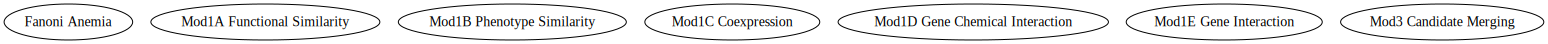

In [5]:
wf2_graph

### Get Fanconi associated genes from BioLink API api.monarchinitative.org

In [6]:
fa_gene_associations = blw.disease2genes(disease_curie=fanconi_anemia)
# load into pandas dataframe
parsed_fa_genes = [blw.parse_association(fanconi_anemia, x) for x in fa_gene_associations['associations']]
for fa_gene in parsed_fa_genes:
    fa_mg = mg.query(fa_gene['hit_id'].replace('HGNC', 'hgnc'), species='human', entrezonly=True, fields='entrez,HGNC,symbol')
    fa_gene.update({'ncbi': 'NCBIGene:{}'.format(fa_mg['hits'][0]['_id'])})
    
fa_genes_df = pd.DataFrame(data=parsed_fa_genes)
# group duplicate ids and gather sources
fa_genes_df['sources'] = fa_genes_df['sources'].str.join(', ')


In [7]:
fa_genes_df = fa_genes_df.groupby(['input', 'hit_id','hit_label', 'ncbi'])['sources'].apply(', '.join).reset_index()

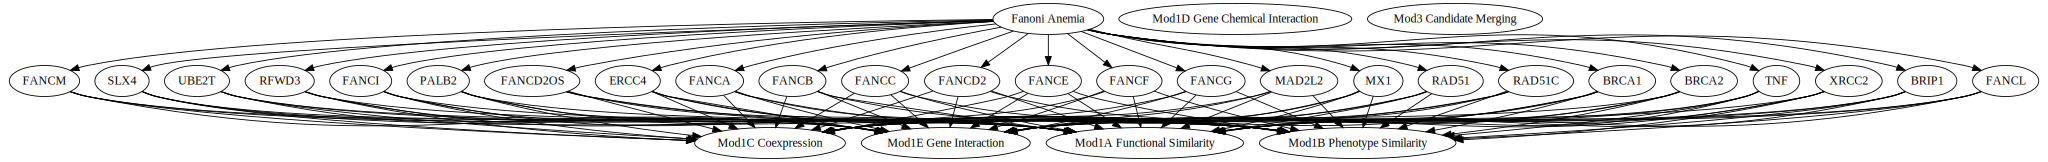

In [40]:
# graph fanconi genes 2 mod1
for index, row in fa_genes_df.iterrows():
    wf2_graph.node(conv_pref(row[1]), label=row[2])
    wf2_graph.edge(conv_pref(fanconi_anemia), conv_pref(row[1]))
    modules = ['Mod1A', 
               'Mod1B', 
               'Mod1C', 
#                'Mod1D', 
               'Mod1E']
    for mod in modules:
        wf2_graph.edge(conv_pref(row[1]), mod)
    
wf2_graph

In [9]:
mod1_candidates = list()

# Mod1A Functional Similarity

In [10]:
from Modules.Mod1A_functional_sim import FunctionalSimilarity

fsim = FunctionalSimilarity()
fsim.load_gene_set(fa_genes_df['hit_id'].tolist()) 
fsim.load_associations() 
results = fsim.compute_similarity()

/Users/tputman/.virtualenvs/modules/lib/python3.6/site-packages/cachier/mongo_core.py:24: UserWarning: Cachier warning: pymongo was not found. MongoDB cores will not work.
  "Cachier warning: pymongo was not found. MongoDB cores will not work.")


In [11]:
Mod1A_results = pd.DataFrame(results)

In [12]:
Mod1A_results = Mod1A_results[~Mod1A_results['sim_hit_name'].isin(fa_genes_df['hit_label'])]

In [13]:
Mod1A_results

,input_curie,sim_hit_curie,sim_hit_name,sim_score
0,HGNC:23845,UniProtKB:Q9BQ83,SLX1A,0.760638
2,HGNC:3583,UniProtKB:Q0VG06,FAAP100,0.810345
3,HGNC:3583,UniProtKB:Q9BTP7,FAAP24,0.903846
5,HGNC:3583,UniProtKB:Q9NRY2,INIP,0.862745
7,HGNC:3586,UniProtKB:Q0VG06,FAAP100,0.775862
9,HGNC:3586,UniProtKB:Q9BTP7,FAAP24,0.865385
11,HGNC:3586,UniProtKB:Q9NRY2,INIP,0.823529
12,HGNC:3587,UniProtKB:Q0VG06,FAAP100,0.810345
13,HGNC:3587,UniProtKB:Q9BTP7,FAAP24,0.903846
15,HGNC:3587,UniProtKB:Q9NRY2,INIP,0.862745


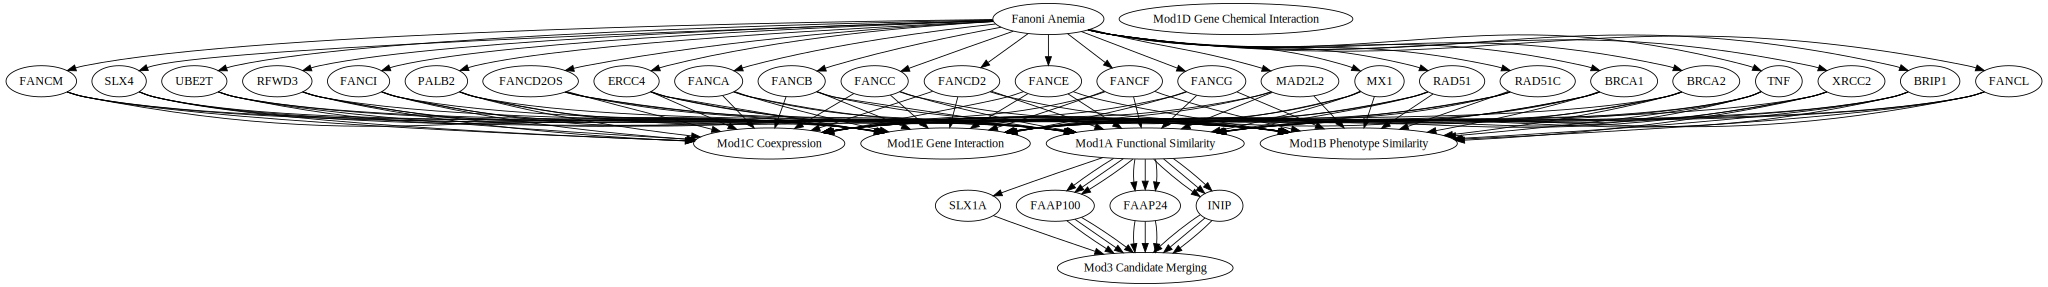

In [41]:
# graph mod1A genes 2 Mod3
for index, row in Mod1A_results.iterrows():
    wf2_graph.node(conv_pref(row[1]), label=row[2])
    wf2_graph.edge('Mod1A', conv_pref(row[1]))
    wf2_graph.edge(conv_pref(row[1]), 'Mod3')
    mod1_candidates.append({
        'input_curie': row[0],
        'output_curie': row[1],
        'output_name': row[2],
        'module': 'Mod1A'
    })
wf2_graph

# Mod1B Phenotype Similarity

In [15]:
from Modules.Mod1B_phenotype_similarity import PhenotypeSimilarity

psg = PhenotypeSimilarity()
psg.load_gene_set(fa_genes_df['hit_id'].tolist()) # TODO run on all fa genes
psg.load_associations()
Mod1B_results = psg.similarity_search()

'label' <SimSearch.simsearch_client.SimScoreMatch object at 0x141377198>


In [16]:
Mod1B_results['hit_id'] = Mod1B_results['id'].apply(map_id)

In [17]:
Mod1B_results = Mod1B_results[~Mod1B_results['label_x'].isin(fa_genes_df['hit_label'])]

In [18]:
Mod1B_results = Mod1B_results[~Mod1B_results['hit_id'].str.contains('MONDO')]

In [19]:
Mod1B_results = Mod1B_results[Mod1B_results['summed_score'] > 100]

In [20]:
Mod1B_results


,input_id_x,id,label_x,summed_score,hit_id
24,HGNC:1100,OMIM:600020,MXI1,144.0,HGNC:7534
26,HGNC:1100,OMIM:605650,POLK,144.0,HGNC:9183
27,HGNC:1100,OMIM:602053,KLF6,144.0,HGNC:2235
29,HGNC:1100,OMIM:602650,SPOP,144.0,HGNC:11254
30,HGNC:1100,OMIM:602686,MAD1L1,144.0,HGNC:6762
31,HGNC:1100,OMIM:313700,AR,142.0,HGNC:644
33,HGNC:1100,OMIM:153622,MSR1,144.0,HGNC:7376
59,HGNC:1100,OMIM:171834,PIK3CA,140.0,HGNC:8975
72,HGNC:1100,OMIM:191170,TP53,138.0,HGNC:11998
93,HGNC:1100,OMIM:604610,BLM,128.0,HGNC:1058


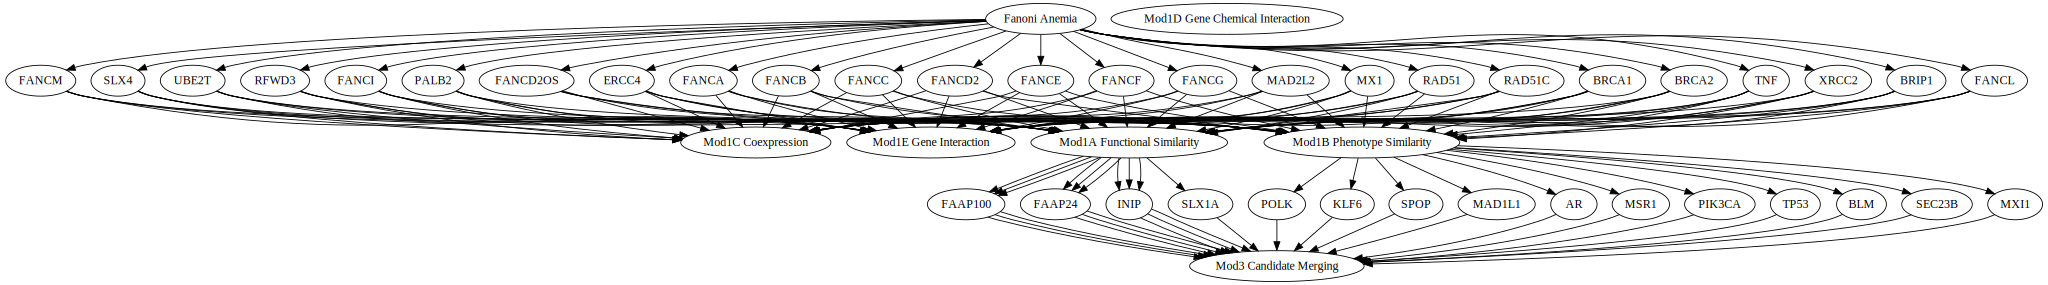

In [42]:
# graph mod1B genes 2 Mod3
for index, row in Mod1B_results.iterrows():
    wf2_graph.node(conv_pref(row[-1]), label=row[2])
    wf2_graph.edge('Mod1B', conv_pref(row[-1]))
    wf2_graph.edge(conv_pref(row[-1]), 'Mod3')
    mod1_candidates.append({
        'input_curie': row[0],
        'output_curie': row[1],
        'output_name': row[2],
        'module': 'Mod1B'
    })
wf2_graph

# Mod1C Coexpression

In [22]:
# TODO

# Mod1D Chemical Gene Interactions

In [23]:
# Needs work, way too many hits 

In [24]:
# increases expression instance
# from Modules.Mod1D_Chemical_Gene import ChemicalGeneInteractions

In [25]:
# use only fa core genes 
# fa_core_genes = ['FANCA','FANCB','FANCC','FANCE','FANCF','FANCG','FANCL','FANCM','FANCD2','FANCI','UBE2T','SLX4']
# fa_genes_df[fa_genes_df['hit_label'].str.contains('|'.join(fa_core_genes))]

In [26]:
# gci = ChemicalGeneInteractions()
# gci.load_gene_set(gene_set=fa_genes_df[fa_genes_df['hit_label'].str.contains('|'.join(fa_core_genes))])
# only return chemicals that decrease expression of fa genes
# gci.get_chemicals(action='decreases^expression')
# gci.load_gene_hits(action='decreases^expression', rows=2)

# Mod1E Gene Interactions

In [27]:
from Modules.Mod1E_interactions import GeneInteractions

gi = GeneInteractions()
gi.load_gene_set(gene_set=fa_genes_df['hit_id'].tolist())
gi.get_interactions()
Mod1E_results = pd.DataFrame(gi.interactions)

In [28]:
Mod1E_results = Mod1E_results[~Mod1E_results['hit_label'].isin(fa_genes_df['hit_label'])]

In [29]:
grouped_Mod1E_results = Mod1E_results.groupby(['hit_id','hit_label'])['input'].apply(', '.join).reset_index()

In [30]:
grouped_Mod1E_results.head()

,hit_id,hit_label,input
0,FlyBase:FBgn0037781,Fancl,HGNC:25009
1,FlyBase:FBgn0050169,Brca2,HGNC:3585
2,HGNC:10050,RNASEL,HGNC:7532
3,HGNC:10061,RNF2,HGNC:1100
4,HGNC:10067,RNF4,"HGNC:25009, HGNC:3582"


In [31]:
trimmed_Mod1E_results = list()
for index, row in grouped_Mod1E_results.iterrows():
    if len(row[-1].split(',')) > 10:
        trimmed_Mod1E_results.append(row)
Mod1E_results = pd.DataFrame(trimmed_Mod1E_results, columns=['hit_id', 'hit_label', 'input'])
Mod1E_results   

,hit_id,hit_label,input
7,HGNC:10289,RPA1,"HGNC:1101, HGNC:12829, HGNC:20748, HGNC:23168,..."
8,HGNC:10290,RPA2,"HGNC:1100, HGNC:1101, HGNC:12829, HGNC:20473, ..."
9,HGNC:10291,RPA3,"HGNC:1101, HGNC:12829, HGNC:20473, HGNC:20748,..."
14,HGNC:10417,RPS27A,"HGNC:1101, HGNC:12829, HGNC:20473, HGNC:20748,..."
22,HGNC:1058,BLM,"HGNC:1101, HGNC:12829, HGNC:20473, HGNC:20748,..."
101,HGNC:11992,TOP3A,"HGNC:1101, HGNC:12829, HGNC:20473, HGNC:20748,..."
120,HGNC:12458,UBA52,"HGNC:12829, HGNC:20473, HGNC:20748, HGNC:23168..."
121,HGNC:12463,UBB,"HGNC:12829, HGNC:20473, HGNC:20748, HGNC:23845..."
122,HGNC:12468,UBC,"HGNC:1101, HGNC:12829, HGNC:20748, HGNC:23845,..."
293,HGNC:17008,TOPBP1,"HGNC:12829, HGNC:20473, HGNC:20748, HGNC:23845..."


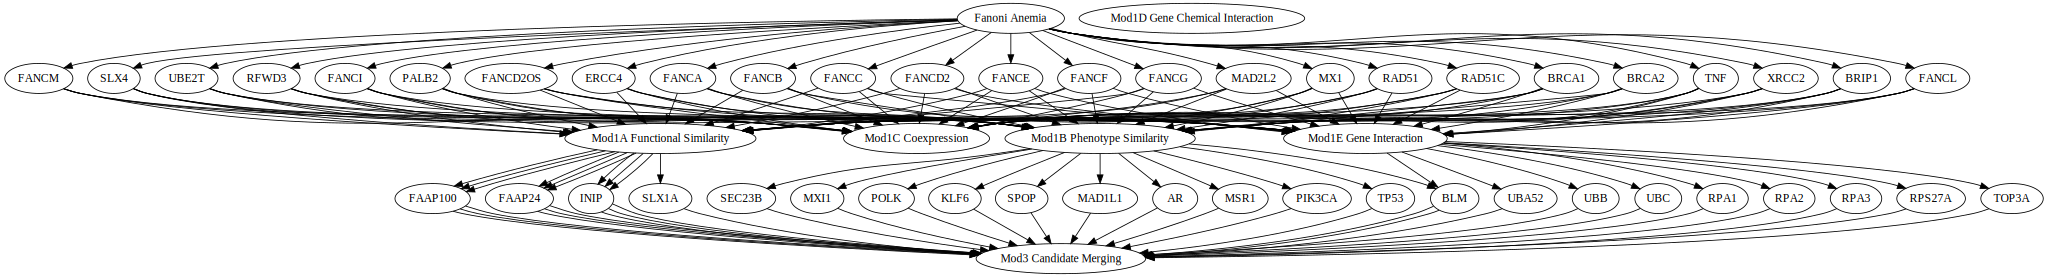

In [43]:
# graph mod1E genes 2 Mod3
for index, row in Mod1E_results.iterrows():
    if index < 200:
        wf2_graph.node(conv_pref(row[0]), label=row[1])
        wf2_graph.edge('Mod1E', conv_pref(row[0]))
        wf2_graph.edge(conv_pref(row[0]), 'Mod3')
        mod1_candidates.append({
            'input_curie': row[-1],
            'output_curie': row[0],
            'output_name': row[1],
            'module': 'Mod1E',
        })
wf2_graph

In [33]:
pd.DataFrame(mod1_candidates)

,input_curie,module,output_curie,output_name
0,HGNC:23845,Mod1A,UniProtKB:Q9BQ83,SLX1A
1,HGNC:3583,Mod1A,UniProtKB:Q0VG06,FAAP100
2,HGNC:3583,Mod1A,UniProtKB:Q9BTP7,FAAP24
3,HGNC:3583,Mod1A,UniProtKB:Q9NRY2,INIP
4,HGNC:3586,Mod1A,UniProtKB:Q0VG06,FAAP100
5,HGNC:3586,Mod1A,UniProtKB:Q9BTP7,FAAP24
6,HGNC:3586,Mod1A,UniProtKB:Q9NRY2,INIP
7,HGNC:3587,Mod1A,UniProtKB:Q0VG06,FAAP100
8,HGNC:3587,Mod1A,UniProtKB:Q9BTP7,FAAP24
9,HGNC:3587,Mod1A,UniProtKB:Q9NRY2,INIP


In [44]:
wf2_graph.render()

'Workfow II Fanconi Anemia Implementation.gv.pdf'